In [1]:
import numpy as np
import torch as t
import torch
import torchvision as tv
from torchvision.transforms import v2
from utils.distortion import DiffeoConfig, band_limited_sparse_transform_amplitude, create_grid_sample

import matplotlib.pyplot as plt

rng = np.random.default_rng(seed = 37)

In [63]:
resolution = 64

diffeo_config = DiffeoConfig(resolution = resolution, strength = [0.5], x_range=[0,3], num_nonzero_params = 1)

A_list = []
B_list = []
for strength in diffeo_config.strength:
    A,B = band_limited_sparse_transform_amplitude(
        x_range = diffeo_config.x_range,
        y_range = diffeo_config.x_range,
        num_of_terms = diffeo_config.num_nonzero_params,
        diffeo_amp = strength,
        num_of_diffeo = diffeo_config.num_diffeo_per_strength,
        seed = 32,
        )
    A_list.append(A)
    B_list.append(B)

AB = torch.stack([torch.cat(A_list), torch.cat(B_list)])

diffeo = create_grid_sample(diffeo_config.resolution, diffeo_config.resolution, A_list, B_list)
diffeo_fn = lambda x: torch.nn.functional.grid_sample(x, diffeo, 
                                                      align_corners=True, 
                                                      mode = 'bilinear',
                                                      padding_mode= 'zeros')

In [64]:
import torch.nn.functional as F
import torch
import torch.nn.functional as F

def translate_images(images: torch.Tensor, tx= 10 , ty = 10) -> torch.Tensor:
    """
    Translate a batch of images by tx pixels horizontally and ty pixels vertically.
    Args:
        images: Input tensor (B, C, H, W)
        tx: Translation in x direction (pixels)
        ty: Translation in y direction (pixels)
    """
    b, _, h, w = images.shape
    theta = torch.tensor([[1, 0, tx/w], 
                         [0, 1, ty/h]], dtype=torch.float)
    
    # Repeat the transformation matrix for each image in the batch
    theta = theta.unsqueeze(0).repeat(b, 1, 1)
    
    grid = F.affine_grid(theta, images.shape, align_corners=False)
    return F.grid_sample(images, grid, align_corners=False)

# Example usage:
# batch = torch.randn(32, 3, 224, 224)  # Batch of 32 images
# translated = translate_images(batch, tx=10, ty=20)  # Translate all images 10px right, 20px down

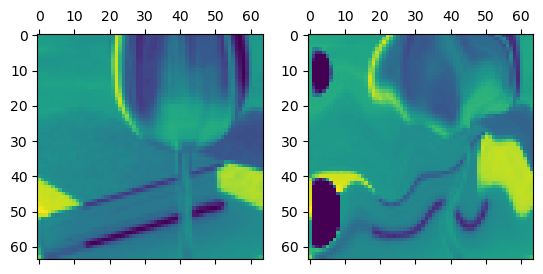

In [65]:
import PIL
from torchvision.transforms import v2
image = PIL.Image.open('data/test_image.png')
transforms  = v2.Compose([
    v2.ToTensor(),
    v2.Resize(int(resolution*1.5)),
    v2.CenterCrop(resolution)
])
tensor = transforms(image).unsqueeze(0)

fig, axes = plt.subplots(1,2)
axes[0].matshow(tensor[0,0])
axes[1].matshow(diffeo_fn(tensor)[0,0])

In [66]:
image = torch.Tensor(torch.stack(t.meshgrid(torch.arange(resolution), torch.arange(resolution), indexing = 'ij')).unsqueeze(0)).float()+10
# image = image.requires_grad_(True)
# distorted = diffeo_fn(image)
# distorted = translate_images(image, tx = 25, ty = 25)
jacobian = torch.autograd.functional.jacobian(diffeo_fn, image).squeeze()

In [67]:
jacobian_small = jacobian[0,:,:,0,:,:].reshape(resolution*resolution, resolution*resolution)
print(f'jacobian have shape {jacobian.shape} and we can flatten it to have shape {jacobian_small.shape}')
print(torch.allclose(jacobian[0,:,:,0,:,:], jacobian[1,:,:,1,:,:]))

jacobian have shape torch.Size([2, 64, 64, 2, 64, 64]) and we can flatten it to have shape torch.Size([4096, 4096])
True


In [68]:
torch.trace(jacobian_small)/resolution**2

tensor(0.0955)

In [69]:
res_list = [16, 18, 20, 22, 24, 28, 32, 36, 42, 50, 56, 60, 64, 68, 72, 76]
y = []
for resolution in res_list:
    diffeo = create_grid_sample(resolution, resolution, A_list, B_list)
    diffeo_fn = lambda x: torch.nn.functional.grid_sample(x, diffeo, 
                                                      align_corners=True, 
                                                      mode = 'bilinear',
                                                      padding_mode= 'zeros')
    image = torch.Tensor(torch.stack(t.meshgrid(torch.arange(resolution), torch.arange(resolution), indexing = 'ij')).unsqueeze(0)).float()
    jacobian = torch.autograd.functional.jacobian(diffeo_fn, image).squeeze()
    jacobian_small = jacobian[0,:,:,0,:,:].reshape(resolution*resolution, resolution*resolution)
    y.append(torch.trace(jacobian_small)/resolution**2)

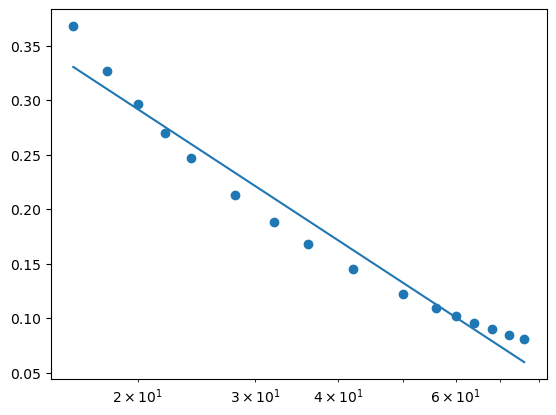

In [70]:
import numpy as np
coefficients = np.polyfit(np.log(np.asarray(res_list)), np.asarray(y), 1)
polynomial = np.poly1d(coefficients)

plt.scatter(res_list, y)
plt.xscale('log')
plt.plot(res_list, polynomial(np.log(np.asarray(res_list))))

In [37]:
def get_zero_eigenvector(m, threshold=1e-7):
    # Get eigenvalues and eigenvectors
    eigenvalues, eigenvectors = torch.linalg.eig(m)
    
    # Find index of eigenvalue closest to zero
    zero_indices = torch.where(torch.abs(eigenvalues) < threshold)[0]
    
    # Extract corresponding eigenvector
    zero_eigenvector = eigenvectors[:, zero_indices].real
    
    return eigenvalues, eigenvectors, zero_eigenvector

eigenval, eigenvec, zero_egvec = get_zero_eigenvector(jacobian_small)

In [38]:
eigenval.abs().sort()

torch.return_types.sort(
values=tensor([0.0000, 0.0000, 0.0000,  ..., 1.0000, 1.0000, 1.0000]),
indices=tensor([158, 131, 137,  ..., 313, 775, 289]))

In [187]:
def get_projection_matrix(V):
    # Normalize columns (eigenvectors)
    # V = V / torch.norm(V, dim=0)
    
    # Create projection matrix P = V(V^T V)^{-1}V^T
    # Since V has orthonormal columns, V^T V = I, so P = VV^T
    P = V @ V.T.conj()
    
    return P.real

proj_matrix = get_projection_matrix(zero_egvec)

In [188]:
zero_subspace = t.einsum('ij, abj -> abi', proj_matrix, tensor.reshape(1,3,-1)).reshape(1,3,resolution,resolution)

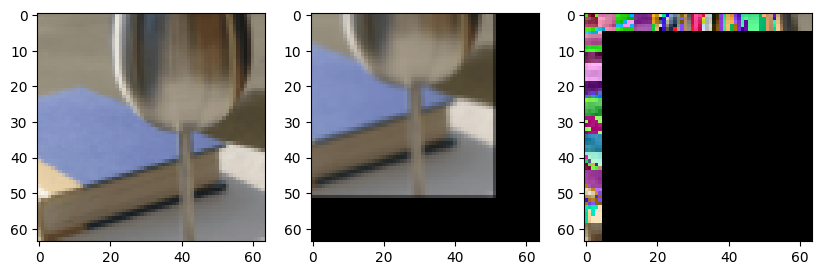

In [189]:
from torchvision.transforms import v2
toImage = lambda x: v2.ToPILImage()(x.squeeze())

fig, axes = plt.subplots(1,3, figsize = (10,30))
axes[0].imshow(toImage(tensor))
# axes[0].imshow(zero_subspace[0,0], cmap = 'Reds', alpha = 0.6)
axes[1].imshow(toImage(translate_images(tensor,tx = 25, ty = 25)))
# axes[1].imshow(zero_subspace[0,0], cmap = 'Reds', alpha = 0.6)
axes[2].imshow(toImage(zero_subspace))

In [254]:
image_2 = torch.einsum('ij, abj -> abi', jacobian_small, image_copy)
image_2 = image_2.reshape(1,2,resolution,resolution)

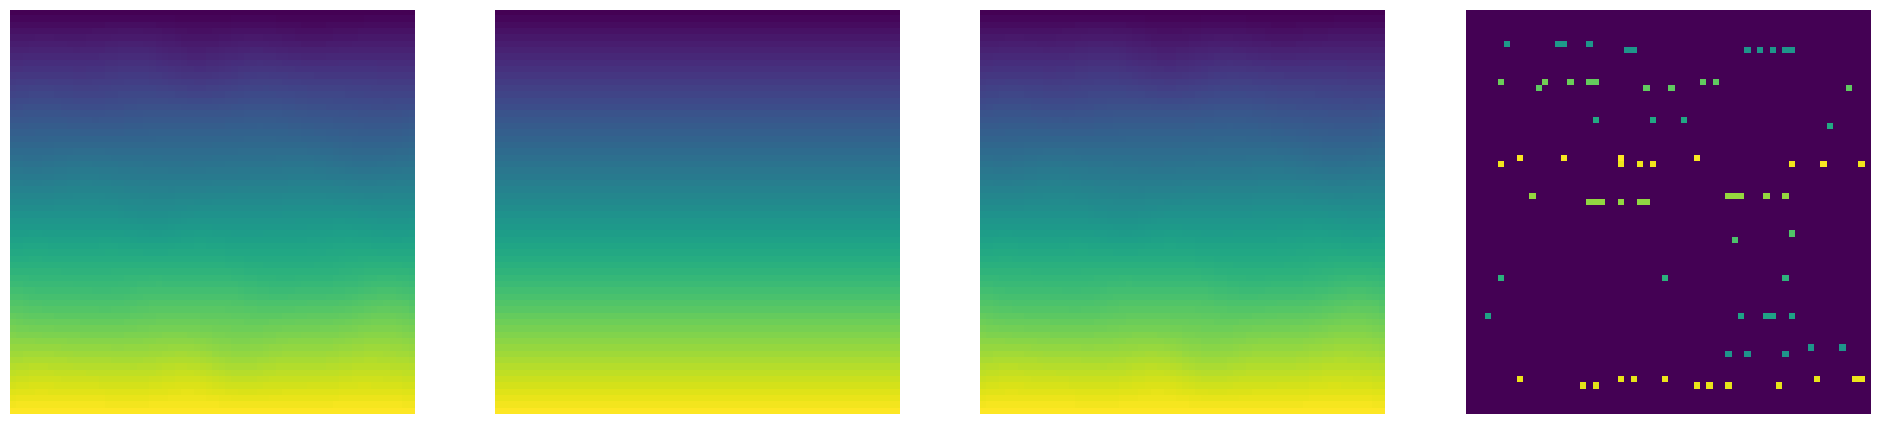

In [255]:
fig, axes = plt.subplots(1,4, figsize=(24, 6))
axes[0].matshow(distorted[0,0].detach())
axes[1].matshow(image[0,0].detach())
axes[2].matshow(image_2[0,0].detach())
axes[3].matshow(((distorted - image_2).abs()/distorted)[0,0])
for ax in axes:
    ax.set_axis_off()

In [256]:
((distorted - image_2).abs()/distorted).max()

tensor(1.2137e-07)

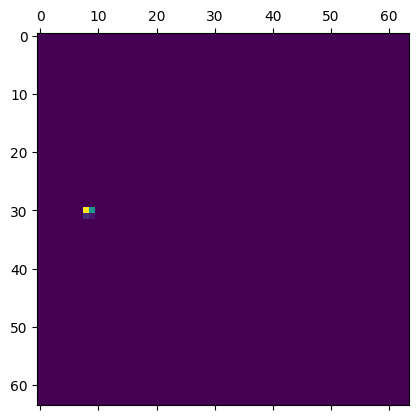

In [257]:
plt.matshow(jacobian_small.reshape(resolution,resolution,resolution,resolution)[30,8,:,:])

In [258]:
torch.linalg.det(jacobian_small)

tensor(0.)

/vast/xj2173/python_envir/cuda_diffeo/lib64/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


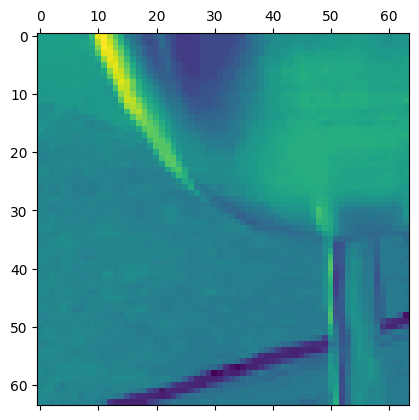

In [16]:
plt.matshow(diffeo_fn(tensor)[0,0])

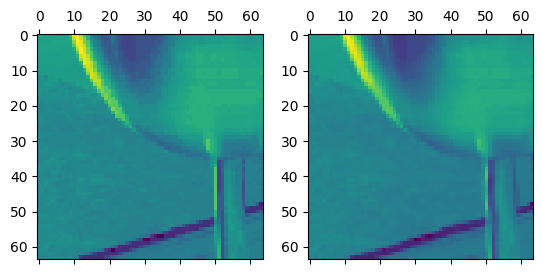

In [58]:
jacobian_small.shape

torch.Size([256, 256])

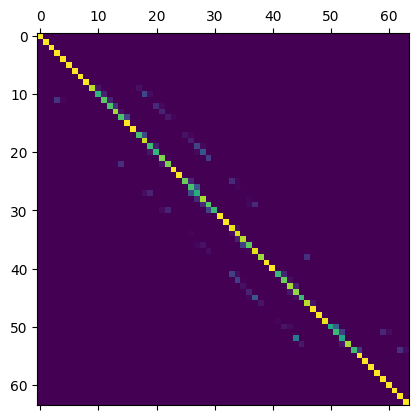

In [67]:
plt.matshow(jacobian_small)

tensor(0.3765)